In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style('darkgrid')

In [3]:
data = pd.read_csv('data/sms.csv')
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5573 entries, 0 to 5572
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5573 non-null   object
 1   Message   5573 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [4]:
# checking for missing values
data.isnull().sum()

Category    0
Message     0
dtype: int64

In [5]:
data['Category'].value_counts()

Category
ham               4825
spam               747
{"mode":"full"       1
Name: count, dtype: int64

In [6]:
# {"mode":"full" is an outlier so we will remove it
outlier_index = data[data['Category'] == '{"mode":"full"'].index[0]
data.drop(outlier_index, inplace=True, axis=0)

<Axes: xlabel='Category'>

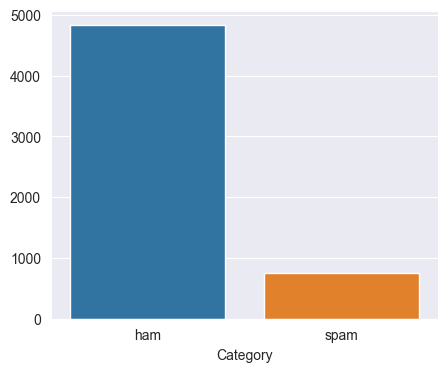

In [43]:
categories = data['Category'].value_counts()

plt.figure(figsize=(5, 4))
sns.barplot(x=categories.index, y=categories.values, hue=categories.index)

In [44]:
# mapping the categories with binary values
data['Category'] = data['Category'].map({'ham': 0, 'spam': 1})
data.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [45]:
from sklearn.model_selection import train_test_split

In [ ]:
X = data['Message'].values
y = data['Category'].values

# splitting the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [65]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, Dense, Bidirectional,
    BatchNormalization, Dropout
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [50]:
max_vocabulary_size = 10000
max_sequence_length = 100

##### **Preprocessing the Texts**

In [ ]:
tokenizer = Tokenizer(num_words=max_vocabulary_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

In [52]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [53]:
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post', truncating='post')

In [58]:
embedding_dim = 100

##### **Building the Model**

In [60]:
model = Sequential([
    # converting texts to dense vectors
    Embedding(input_dim=max_vocabulary_size, output_dim=embedding_dim, input_length=max_sequence_length),

    # bidirectional LSTM 
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [61]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

In [64]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         84480     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4

In [66]:
history = model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
    ], verbose=1
)

Epoch 1/10
112/112 [==============================] - 23s 129ms/step - loss: 0.3432 - accuracy: 0.8614 - val_loss: 0.2404 - val_accuracy: 0.9720 - lr: 0.0010
Epoch 2/10
112/112 [==============================] - 14s 122ms/step - loss: 0.0839 - accuracy: 0.9840 - val_loss: 0.1024 - val_accuracy: 0.9787 - lr: 0.0010
Epoch 3/10
112/112 [==============================] - 17s 149ms/step - loss: 0.0321 - accuracy: 0.9947 - val_loss: 0.0914 - val_accuracy: 0.9821 - lr: 0.0010
Epoch 4/10
112/112 [==============================] - 17s 154ms/step - loss: 0.0386 - accuracy: 0.9927 - val_loss: 0.0812 - val_accuracy: 0.9809 - lr: 0.0010
Epoch 5/10
112/112 [==============================] - 17s 151ms/step - loss: 0.0120 - accuracy: 0.9978 - val_loss: 0.1009 - val_accuracy: 0.9821 - lr: 0.0010
Epoch 6/10
112/112 [==============================] - 16s 144ms/step - loss: 0.0093 - accuracy: 0.9994 - val_loss: 0.0948 - val_accuracy: 0.9832 - lr: 0.0010
Epoch 7/10
112/112 [==============================] 

In [68]:
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test accuracy: {test_accuracy * 100: .2f}%")

35/35 [==============================] - 1s 25ms/step - loss: 0.0747 - accuracy: 0.9883
Test accuracy:  98.83%


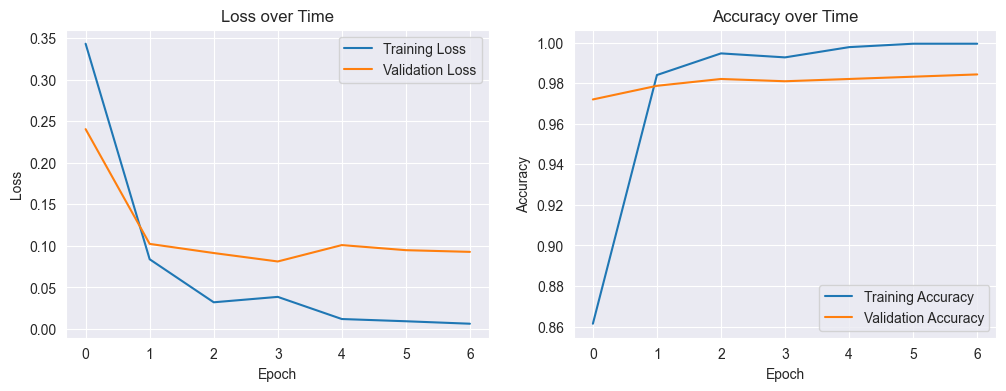

In [85]:
# plotting training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

##### **Evaluating the Model**

In [80]:
from sklearn.metrics import classification_report

In [81]:
y_pred = (model.predict(X_test_pad) > 0.5).astype('int8').ravel()
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))

35/35 [==============================] - 1s 24ms/step
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       966
        spam       0.98      0.93      0.96       149

    accuracy                           0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



In [ ]:
# saving the model
model.save("model/my-model.keras")

In [ ]:
import pickle

# saving the tokenizer
with open("model/my-tokenizer.pkl", "wb") as file:
    pickle.dump(tokenizer, file)